In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import pandas_datareader.data as web
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
import math 
from math import sqrt
from sklearn.metrics import mean_squared_error
import yfinance as yf
from yahoofinancials import YahooFinancials


**Starting our Capstone project by analyzing and visualizing 3 different tech company stock prices (Apple, Google, Microsoft)**

**1. Data Wrangling and Exploratory Data Analysis**

In [101]:
#collecting 5 years data from yahoo
start = dt.datetime(2014,1,1)
end = dt.datetime(2018,12,31)
google = yf.download('GOOG', start=start, end=end, progress=False)
apple = yf.download('AAPL', start=start, end=end, progress=False)
microsoft = yf.download('MSFT', start=start, end=end, progress=False)
google.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,555.647278,556.788025,552.060730,554.481689,554.481689,3656454
2014-01-03,555.418152,556.379578,550.401978,550.436829,550.436829,3345894
2014-01-06,554.426880,557.340942,551.154114,556.573853,556.573853,3551864
2014-01-07,560.399475,567.717041,558.486633,567.303589,567.303589,5124336
2014-01-08,570.860291,571.517822,564.528992,568.484192,568.484192,4501811


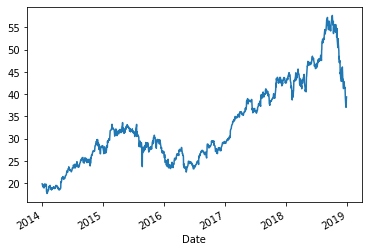

In [102]:
apple['Open'].plot()
plt.show()

**We create a plot that shows the price of 3 stocks in the last 5 years, using open prices.**

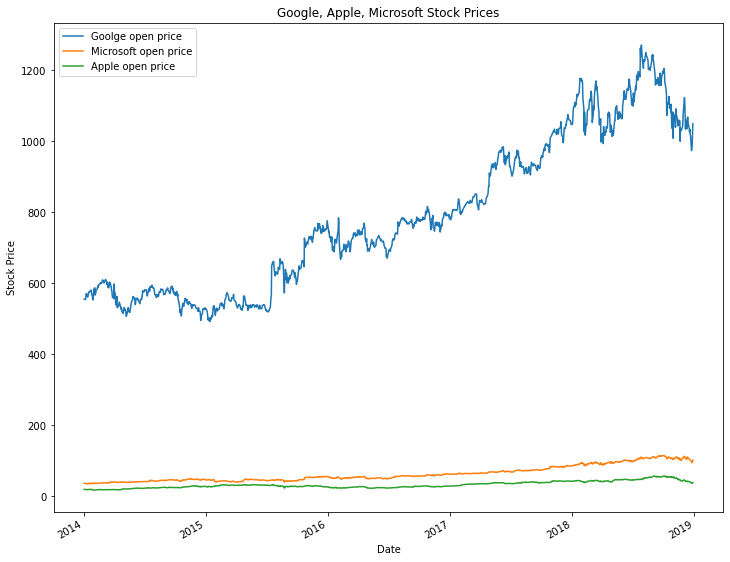

In [103]:
google['Open'].plot(label = 'Goolge open price', figsize=(12, 10))
microsoft['Open'].plot(label = 'Microsoft open price', figsize=(12, 10))
apple['Open'].plot(label = 'Apple open price', figsize=(12, 10))
plt.legend()
plt.title('Google, Apple, Microsoft Stock Prices')
plt.ylabel('Stock Price')
plt.show()

**Next, we create a plot to show the volume for all 3 stocks, in this plot we can see that apple is having the highest trading volume amongst the other stocks, this can be due to the price, since the price is cheaper per share, it requires less investment to buy more shares, compare to google.**

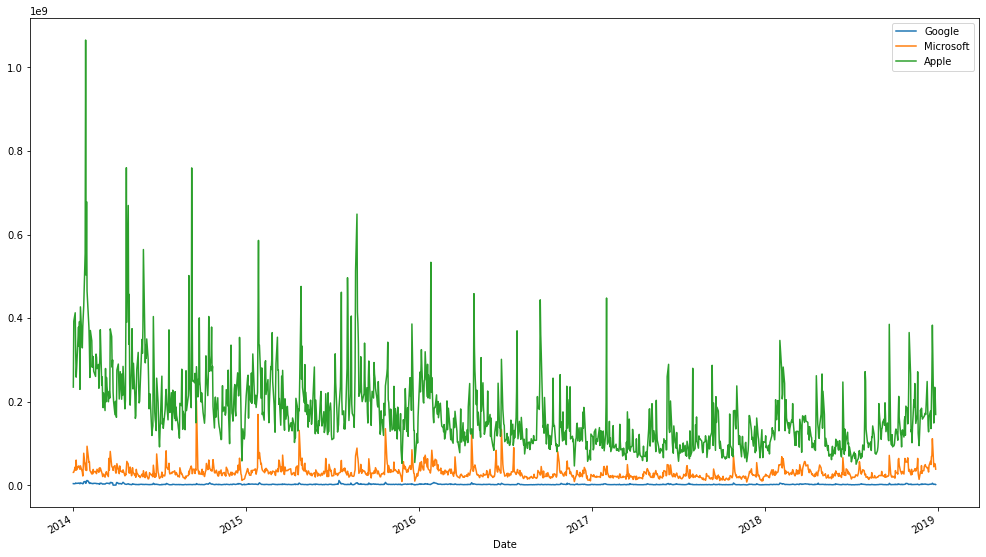

In [104]:

google['Volume'].plot(label='Google', figsize = (17,10))
microsoft['Volume'].plot(label='Microsoft', figsize = (17,10))
apple['Volume'].plot(label='Apple', figsize = (17,10))
plt.legend()
plt.show()

**Next we visualize the daily percentage change for all three stocks and compare them together, seems like they all are very similar**

In [105]:
google['daily_perc_change'] = google['Close'].pct_change()*100
microsoft['daily_perc_change'] = microsoft['Close'].pct_change()*100
apple['daily_perc_change'] = apple['Close'].pct_change()*100



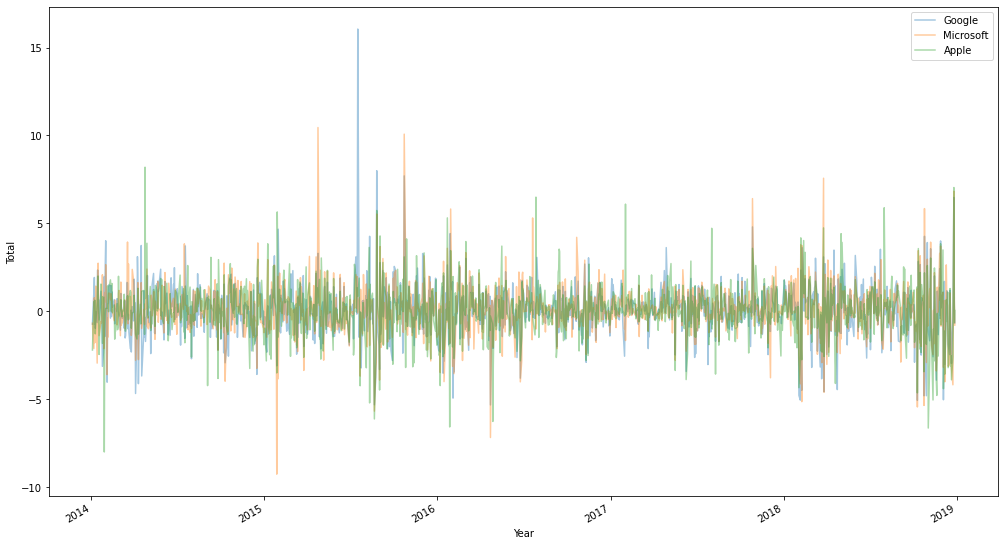

In [106]:

google['daily_perc_change'].plot(figsize = (17, 10), label= 'Google', alpha=0.4)
microsoft['daily_perc_change'].plot(figsize = (17, 10), label= 'Microsoft', alpha=0.4)
apple['daily_perc_change'].plot(figsize = (17, 10), label= 'Apple', alpha=0.4)
subplot= True
plt.legend()
plt.ylabel('Total')
plt.xlabel('Year')
plt.show()

**We try to find the total traded amount for all three stocks, we can see that for the total value of share traded, Apple has the highest amount amongst all and it has been like this consistently over 5 years.**

In [107]:
google['Total'] = google['Open'] * google['Volume']
microsoft['Total'] = microsoft['Open'] * microsoft['Volume']
apple['Total'] = apple['Open'] * apple['Volume']

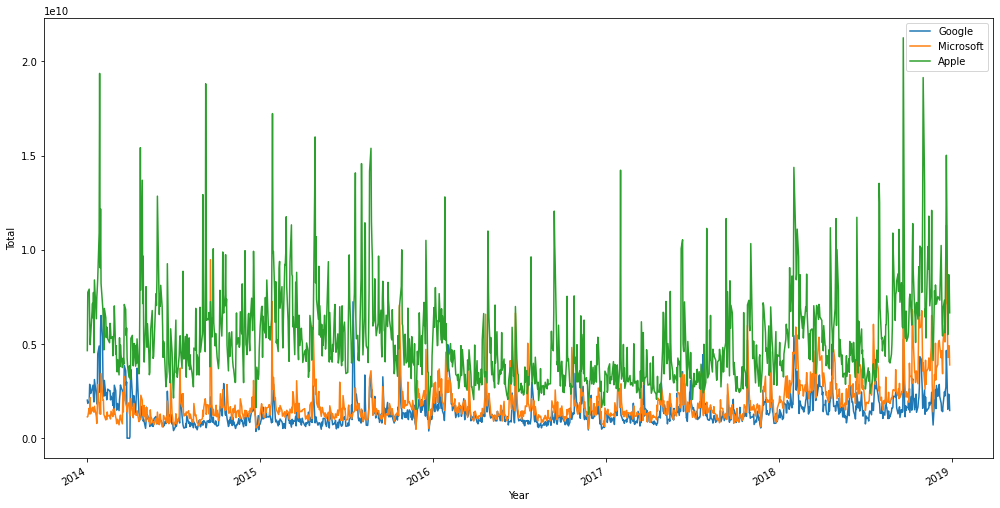

In [108]:
google['Total'].plot(label='Google', figsize=(17,9))
microsoft['Total'].plot(label='Microsoft', figsize=(17,9))
apple['Total'].plot(label='Apple', figsize=(17,9))
plt.legend()
plt.ylabel('Total')
plt.xlabel('Year')
plt.show()

**Next we try smooth out price trends by filtering out the “noise” from random short-term price fluctuations, which is called moving average, We find the 50 day moving average of all three stocks**

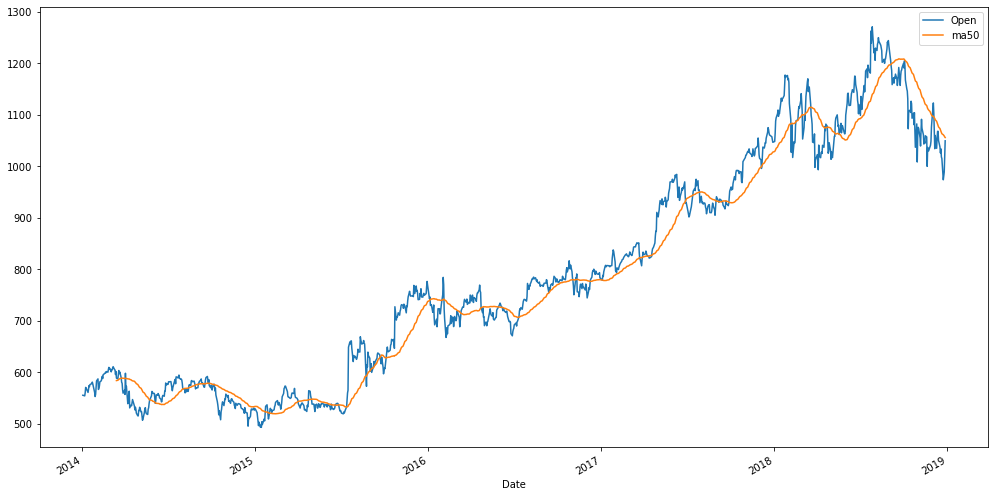

In [109]:
#moving average with 50 day window
google['Open'].plot(figsize=(17,9))
google['ma50'] = google['Open'].rolling(window=50).mean()
google['ma50'].plot(label='ma50')
plt.legend()

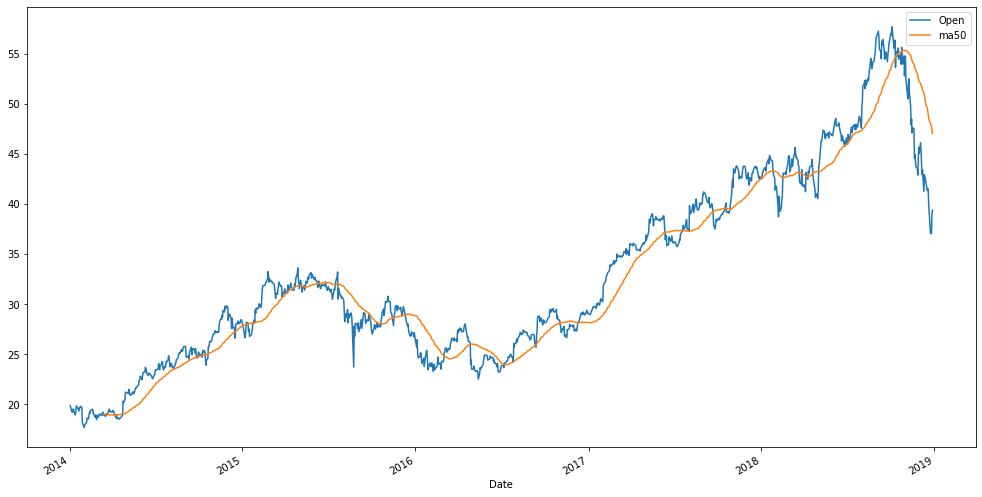

In [110]:
apple['Open'].plot(figsize=(17,9))
apple['ma50'] = apple['Open'].rolling(window=50).mean()
apple['ma50'].plot(label='ma50')
plt.legend()

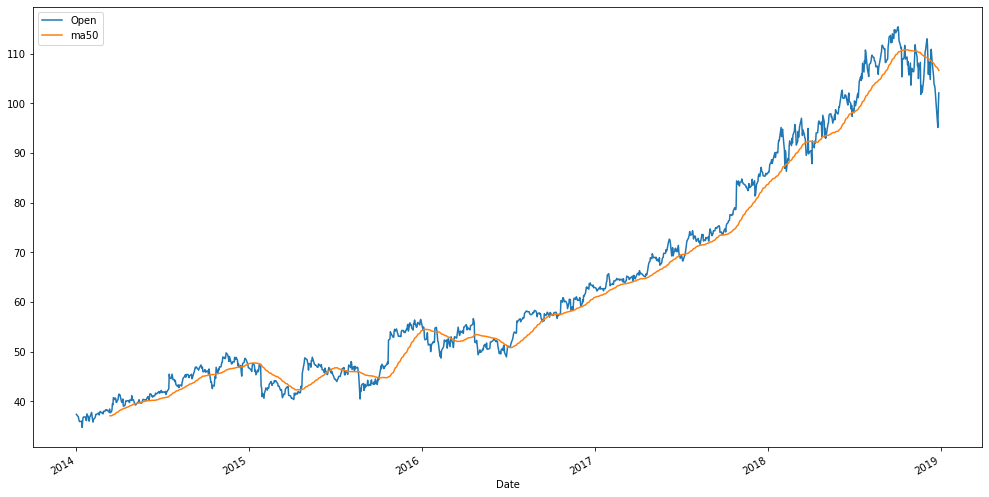

In [111]:
microsoft['Open'].plot(figsize=(17,9))
microsoft['ma50'] = microsoft['Open'].rolling(window=50).mean()
microsoft['ma50'].plot(label='ma50')
plt.legend()

**This section we try to find a linear correlation between the three stocks, to see if they have any type of relationships, since they are all in tech industry. We do that by using the scatter_matrix**

In [112]:
from pandas.plotting import scatter_matrix

In [113]:
#correlation analysis with scatter matrix
tech = pd.concat([google['Open'], apple['Open'], microsoft['Open']], axis=1)
tech.columns = ['google open', 'apple open', 'microsoft open']
tech.head()

,google open,apple open,microsoft open
Date,,,
2014-01-02,555.647278,19.845715,37.349998
2014-01-03,555.418152,19.745001,37.200001
2014-01-06,554.426880,19.194643,36.849998
2014-01-07,560.399475,19.440001,36.330002
2014-01-08,570.860291,19.243214,36.000000


**We can see from our scatter matrix, that all three stocks are very linearly correlated!**

array([[<AxesSubplot:xlabel='google open', ylabel='google open'>,
        <AxesSubplot:xlabel='apple open', ylabel='google open'>,
        <AxesSubplot:xlabel='microsoft open', ylabel='google open'>],
       [<AxesSubplot:xlabel='google open', ylabel='apple open'>,
        <AxesSubplot:xlabel='apple open', ylabel='apple open'>,
        <AxesSubplot:xlabel='microsoft open', ylabel='apple open'>],
       [<AxesSubplot:xlabel='google open', ylabel='microsoft open'>,
        <AxesSubplot:xlabel='apple open', ylabel='microsoft open'>,
        <AxesSubplot:xlabel='microsoft open', ylabel='microsoft open'>]],
      dtype=object)

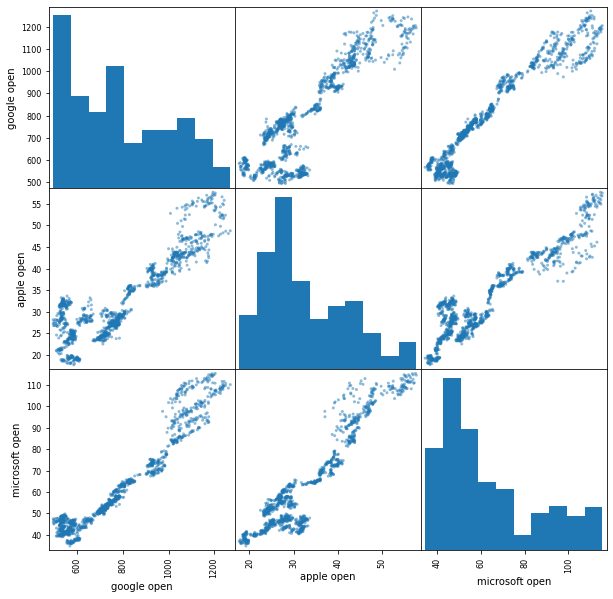

In [114]:
scatter_matrix(tech, figsize=(10, 10))

**Here, we calculate daily price percentage change, for all three stocks (This measure is used for short term investments). This will give us the volatility of each stock and we use histogram to visualize it, the wider the distribution of daily price change, the more volatile the stock is (the width is the standard deviation). We can see here, that all 3 stocks are equally volatile** 


In [115]:
google['returns'] = (google['Close']/google['Close'].shift(1))-1
apple['returns'] = (apple['Close']/apple['Close'].shift(1))-1
microsoft['returns'] = (microsoft['Close']/microsoft['Close'].shift(1))-1


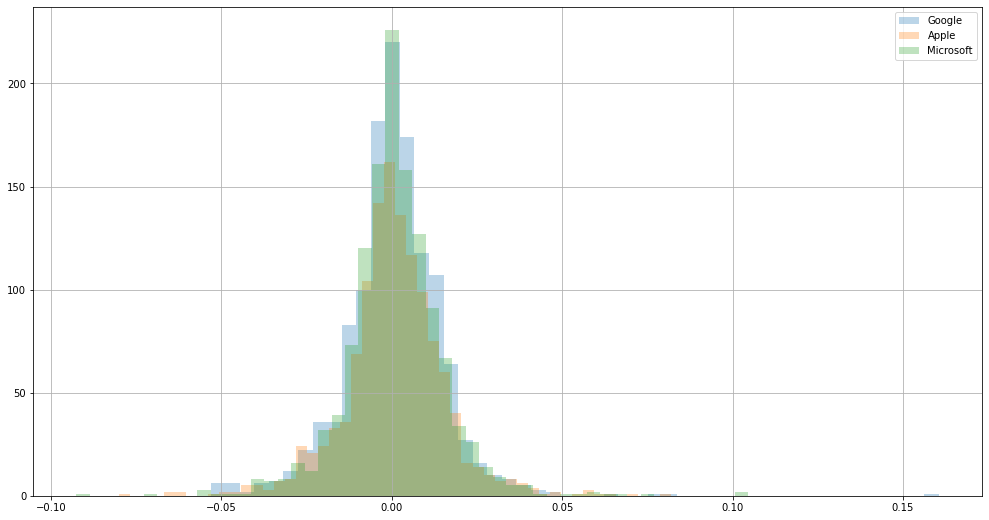

In [116]:
google['returns'].hist(bins = 50, label='Google', alpha=0.3, figsize=(17,9))
apple['returns'].hist(bins = 50, label='Apple', alpha=0.3, figsize=(17,9))
microsoft['returns'].hist(bins = 50, label='Microsoft', alpha=0.3, figsize=(17,9))
plt.legend()

**kernel density estimate (KDE) is a way to estimate the probability density function of a random variable. It normalizes the above histogram, we can see that they are very similar as far as the width.** 

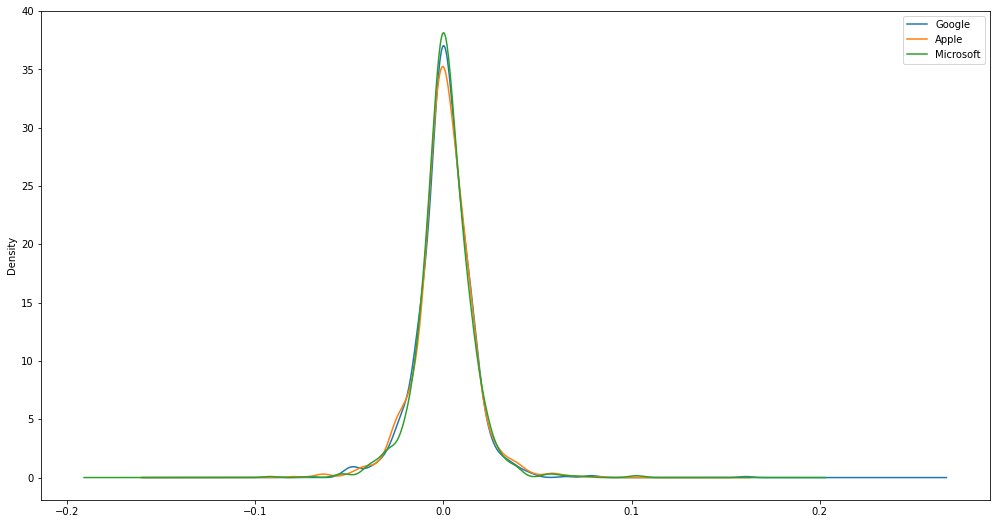

In [117]:
google['returns'].plot(kind='kde', label='Google', figsize=(17,9))
apple['returns'].plot(kind='kde', label='Apple', figsize=(17,9))
microsoft['returns'].plot(kind='kde', label='Microsoft', figsize=(17,9))
plt.legend()


**Here we use box plot to see the volatility for each stock compare to each other, volatility box plot, shows that Microsoft might be slightly more volatile than the other ones (this could be due to presence of more outliers)**

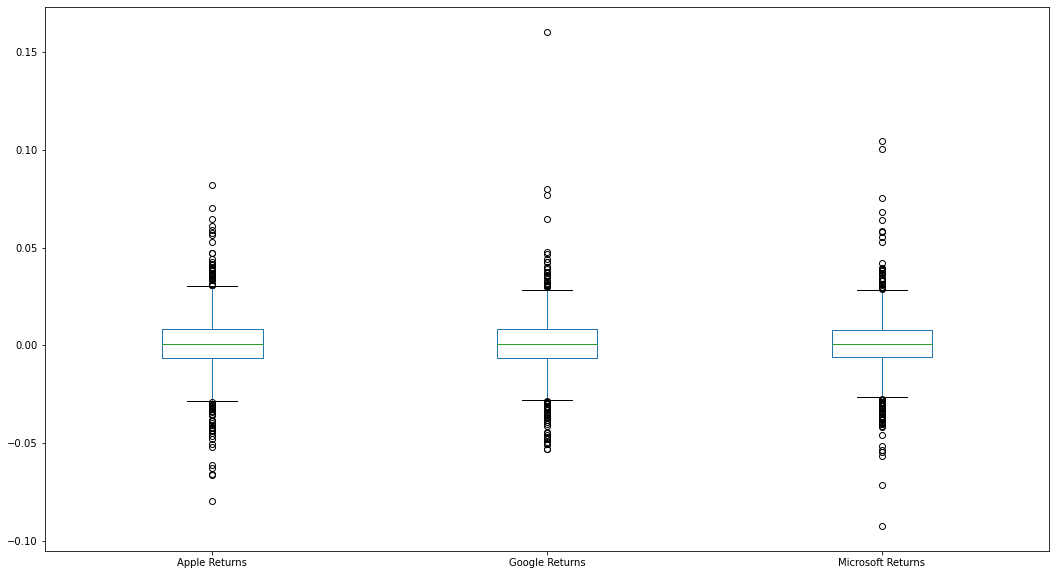

In [118]:
box_plot = pd.concat([apple['returns'], google['returns'], microsoft['returns']], axis=1)
box_plot.columns = ['Apple Returns', 'Google Returns', 'Microsoft Returns']
box_plot.plot(kind='box', figsize=(18,10))
plt.show()

**Last section, we calculate the cumulative returns for three stocks, (this measure is used for long term investment) and plot them, we can see that the highest cumulative return over the 5 years is for Microsoft, apple is slightly lower and google is the lowest.**

In [119]:
#cumulative return, relative to the date investement happened 
google['Cumulative_Return'] = (1 + google['returns']).cumprod()
apple['Cumulative_Return'] = (1 + apple['returns']).cumprod()
microsoft['Cumulative_Return'] = (1 + microsoft['returns']).cumprod()


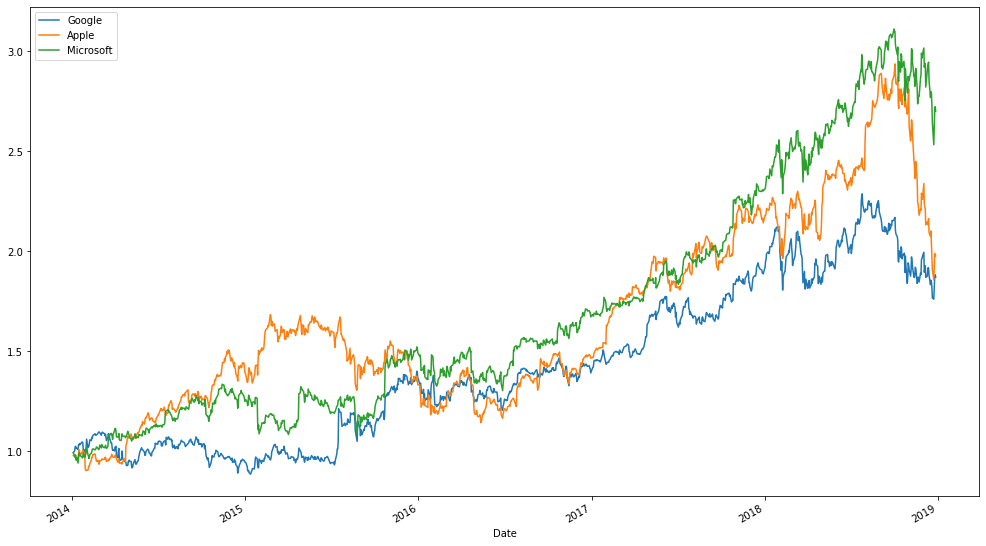

In [120]:
# cumulative return
google['Cumulative_Return'].plot(label='Google', figsize=(17,10))
apple['Cumulative_Return'].plot(label='Apple', figsize=(17,10))
microsoft['Cumulative_Return'].plot(label='Microsoft', figsize=(17,10))
plt.legend()

**2. Preproccesing and modeling**

**Null Hypothesis :** can our time series data be represented as a unit root, that it is non-stationary(time dependent structure or how strongly timeseries define by trend)? 

To find the answer, we calculate p_value by using Augmented Dickey_Fuller test, and since the p_value for all three stock datas are higher than 0.05, we fail to reject the null hypothesis, so, all three timeseries do not have unit roots, are non-stationary and do not have time_dependent structure. So, in order to accurately build the model, we have to find order of differencing to make it stationary

In [121]:
hype2 = adfuller(google.Close.dropna())
hype2[1]

0.8598719021168792

In [122]:
hype3 = adfuller(apple.Close.dropna())
hype3[1]

0.574192945431802

In [123]:
hype1 = adfuller(microsoft.Close.dropna())
hype1[1]

0.9630102468317527

Another way to find if our data is non-stationarity is to look at the acf plot. For the a stationary time series, the ACF will drop to zero relatively quickly, while the non_stationary data decreases slowly.

We now plot the acf to see how the lags are showing and since the data lags decrease slowly, we know that our time series is non_statinary.

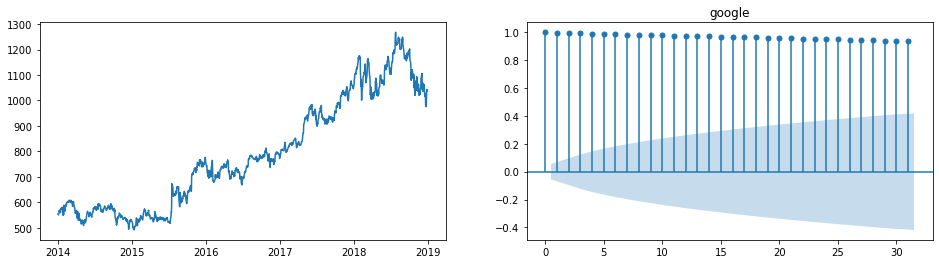

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(google.Close)
plot_acf(google.Close, ax=ax2)
ax2.set_title('google');

As concluded above, We know that our timeseries is non_stationary, so we try to find the returns of the timeseries, as it can be stationary, since, they are usually distributed around the mean. We 
use diff function to find the returns.

Also, we need to find the order of differencing for the timeseries, we plot the ACF plot, which tells us how many turns remove the 
autocorrelation in the series.

q is the order of moving average term, number of lag forecast errors that should go in the ARIMA model, we can find it in our acf plot, which in this case is 3 (third lag is above the line) order (p, d, p)

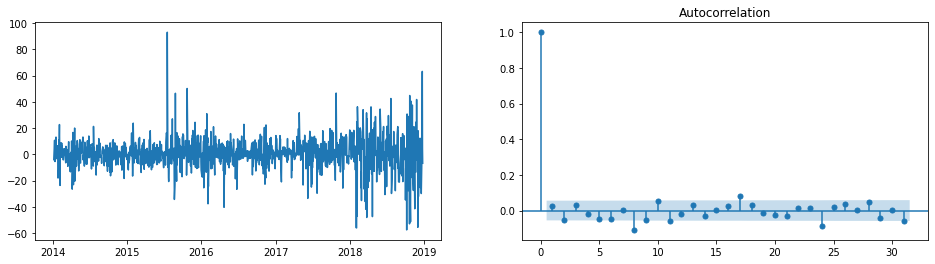

In [125]:
diff = google.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
plot_acf(diff, ax=ax2);



Next, in order to build our ARIMA model, we need to find P, which is the order of autoregressive (AR part of ARIMA model) term, it refers to number of lags to be used as predictors, we use pacf which shows the correlation between series and its lags, which in this case is 3 (third lag is above the line)

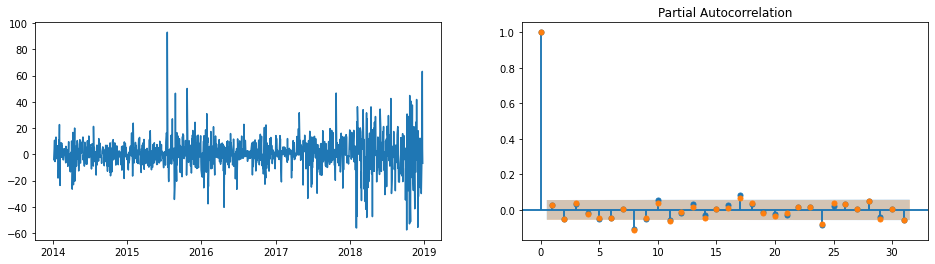

In [126]:
plot_pacf(diff, ax=ax2)

Usefull method to estimate ARIMA differencing term (d) is using ndiffs, which will give us 1, which will be our order of differencing. 

In [127]:

ndiffs(google.Close, test='adf')

1

In [128]:

google_train_data, google_test_data = google[0: int(len(google)*0.8)], google[int(len(google)*0.8) :]

In [129]:
google_train_data.shape

(1005, 11)

Now, we have all the information to build our ARIMA model. The order is (q, d, p), which for our case is (3,1,3).

In [130]:


model = ARIMA(google.Close, order=(3,1,3))
result = model.fit(disp=0)
print(result.summary())

/Users/sima/opt/anaconda3/envs/snowflakes/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/sima/opt/anaconda3/envs/snowflakes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1256
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4885.542
Method:                       css-mle   S.D. of innovations             11.802
Date:                Fri, 02 Jul 2021   AIC                           9787.084
Time:                        23:14:42   BIC                           9828.170
Sample:                             1   HQIC                          9802.526
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4160      0.194      2.148      0.032       0.036       0.796
ar.L1.D.Close     0.1791      0.041      4.355      0.000       0.098       0.260
ar.L2.D.Close    -0.2364      0.032     

The density plot suggest normal distribution with mean zero. The time plot of the residuals shows that the variation of the residuals stays much the same across the historical data, apart from the some outlier, and therefore the residual variance can be treated as constant. The forecast from this model is probably quite good!

(array([6.54595581e-04, 1.47284006e-03, 7.09145213e-03, 4.05303764e-02,
        1.62012406e-02, 2.01833637e-03, 3.81847422e-04, 1.09099263e-04,
        0.00000000e+00, 5.45496317e-05]),
 array([-53.36206798, -38.76658276, -24.17109754,  -9.57561232,
          5.01987291,  19.61535813,  34.21084335,  48.80632858,
         63.4018138 ,  77.99729902,  92.59278424]),
 <BarContainer object of 10 artists>)

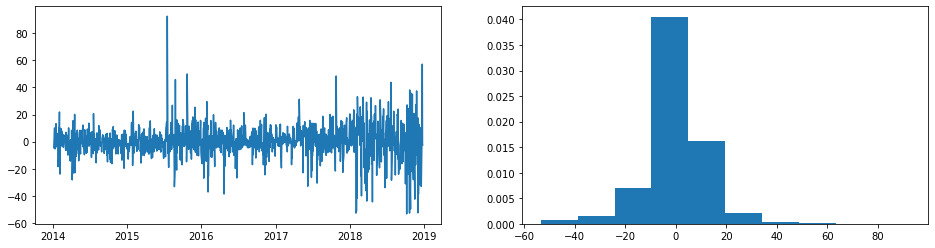

In [131]:
residuals= pd.DataFrame(result.resid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(residuals)
ax2.hist(residuals, density=True)

we use plot_predict to visualize our model, which shows our prediction looks really similar to the actual data. We repeat the same process for Apple and Microsoft data.

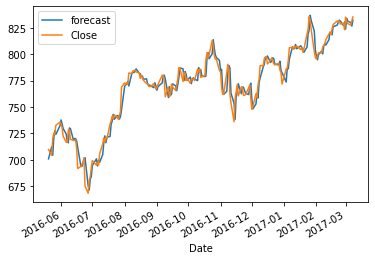

In [132]:
result.plot_predict(start=600, end=800, dynamic=False);

<AxesSubplot:xlabel='Date'>

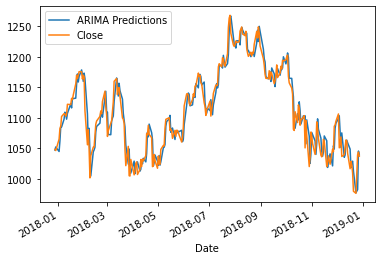

In [133]:
start = len(google_train_data)
end = len(google_train_data) + len(google_test_data)-1
google_pred = result.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')
google_pred.plot(legend=True)
google_test_data['Close'].plot(legend=True)

In [134]:
google_test_data['Close'].mean()


1113.0096774631077

In [135]:
google_rmse = sqrt(mean_squared_error(google_pred,google_test_data['Close']))
print(google_rmse)

18.661422048814895


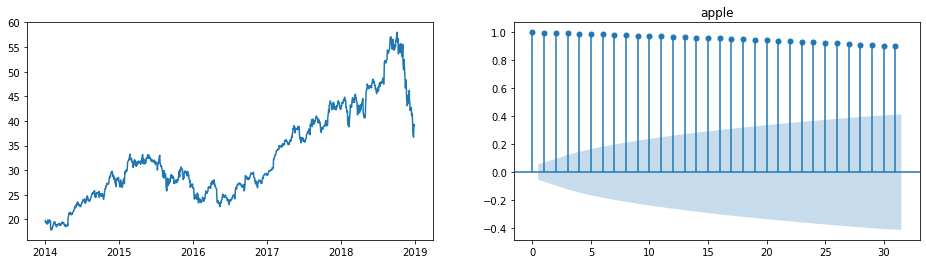

In [136]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16,4))
ax3.plot(apple.Close)
plot_acf(apple.Close, ax=ax4)
ax4.set_title('apple');

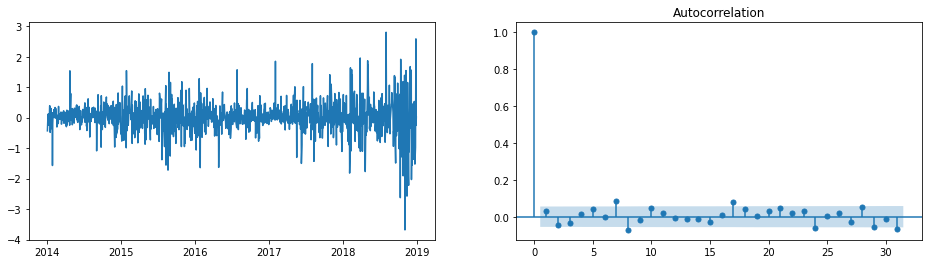

In [137]:
diff = apple.Close.diff().dropna()
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16,4))
ax3.plot(diff)
plot_acf(diff, ax=ax4);



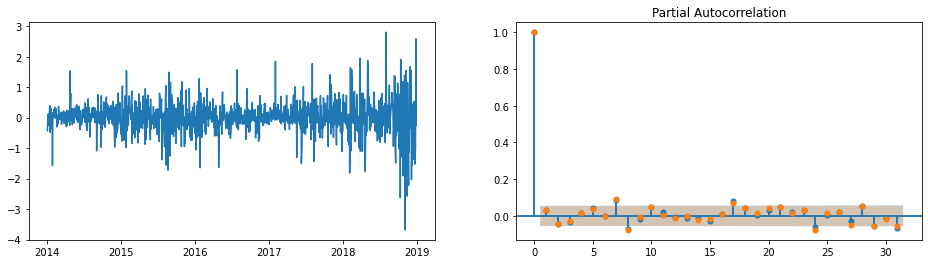

In [138]:
plot_pacf(diff, ax=ax4)

In [139]:
ndiffs(apple.Close, test='adf')

1

In [140]:
# ARIMA model characterise by 3 terms p,d,q 
model_apple = ARIMA(apple.Close, order = (3,1,7))
apple_result = model_apple.fit(disp = 0)
print(apple_result.summary())

/Users/sima/opt/anaconda3/envs/snowflakes/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/sima/opt/anaconda3/envs/snowflakes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1256
Model:                 ARIMA(3, 1, 7)   Log Likelihood                -956.032
Method:                       css-mle   S.D. of innovations              0.518
Date:                Fri, 02 Jul 2021   AIC                           1936.064
Time:                        23:14:55   BIC                           1997.692
Sample:                             1   HQIC                          1959.226
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0152      0.015      1.004      0.315      -0.014       0.045
ar.L1.D.Close    -0.8189      0.183     -4.471      0.000      -1.178      -0.460
ar.L2.D.Close    -0.9438      0.163     

In [141]:
apple_residuals = pd.DataFrame(apple_result.resid)

(array([0.00130323, 0.0039097 , 0.0117291 , 0.03649052, 0.20330435,
        0.95396657, 0.35708585, 0.05082609, 0.0156388 , 0.00260647]),
 array([-3.42652971, -2.81560417, -2.20467862, -1.59375308, -0.98282754,
        -0.37190199,  0.23902355,  0.8499491 ,  1.46087464,  2.07180018,
         2.68272573]),
 <BarContainer object of 10 artists>)

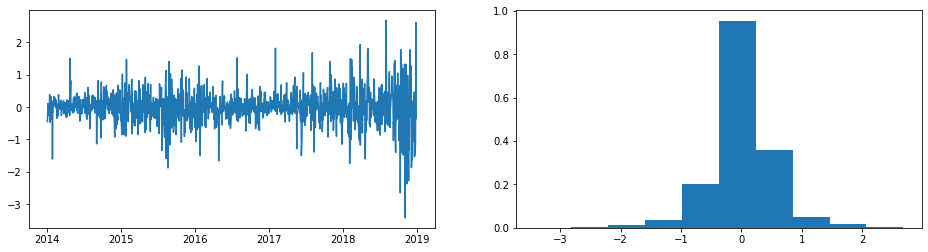

In [142]:


fig, (ax3, ax4) = plt.subplots(1, 2, figsize = (16,4))
ax3.plot(apple_residuals)
ax4.hist(apple_residuals, density=True)

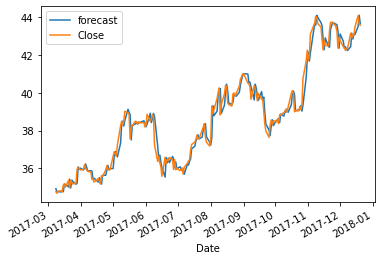

In [143]:
apple_result.plot_predict(start=800, end=1000, dynamic=False);

In [144]:
apple_train_data, apple_test_data = apple[0: int(len(apple)*0.8)], apple[int(len(apple)*0.8) :]

<AxesSubplot:xlabel='Date'>

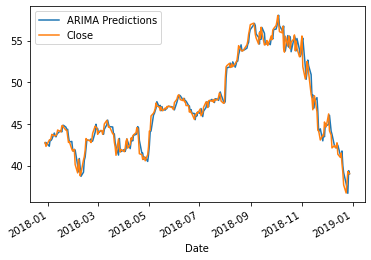

In [145]:
start = len(apple_train_data)
end = len(apple_train_data) + len(apple_test_data)-1
apple_pred = apple_result.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')
apple_pred.plot(legend=True)
apple_test_data['Close'].plot(legend=True)

In [146]:
apple_test_data['Close'].mean()


47.25692472003755

In [147]:
apple_rmse = sqrt(mean_squared_error(apple_pred,apple_test_data['Close']))
print(apple_rmse)

0.8256302758470017


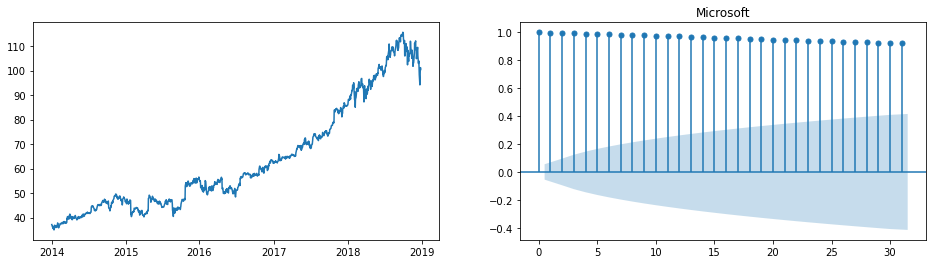

In [148]:
fig, (ax5, ax6) = plt.subplots(1,2, figsize =(16,4))
ax5.plot(microsoft.Close)
plot_acf(microsoft.Close, ax=ax6)
ax6.set_title('Microsoft');

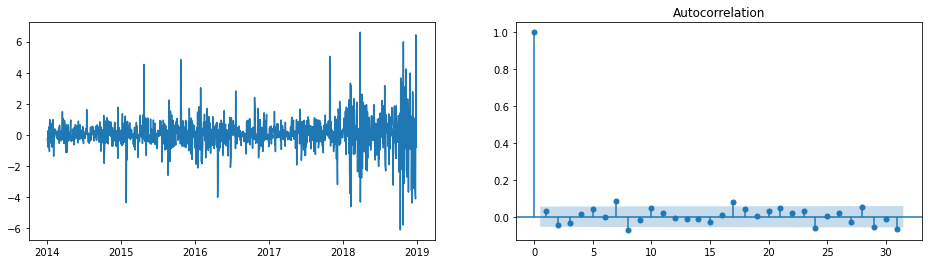

In [149]:


microsoft_diff = microsoft.Close.diff().dropna()
fig, (ax5,ax6) = plt.subplots(1,2, figsize=(16,4))
ax5.plot(microsoft_diff)
plot_acf(diff, ax=ax6);

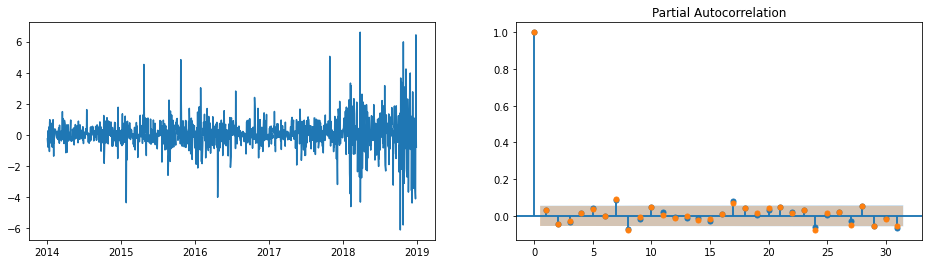

In [150]:
plot_pacf(diff, ax6)

In [151]:
ndiffs(microsoft.Close, test='adf')

1

In [152]:
mic_model = ARIMA(microsoft.Close, order= (0,1,7))
mic_result = mic_model.fit(disp = 0)
print(mic_result.summary())


/Users/sima/opt/anaconda3/envs/snowflakes/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/sima/opt/anaconda3/envs/snowflakes/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1256
Model:                 ARIMA(0, 1, 7)   Log Likelihood               -1783.007
Method:                       css-mle   S.D. of innovations              1.001
Date:                Fri, 02 Jul 2021   AIC                           3584.014
Time:                        23:15:07   BIC                           3630.235
Sample:                             1   HQIC                          3601.386
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0510      0.020      2.614      0.009       0.013       0.089
ma.L1.D.Close    -0.1189      0.029     -4.078      0.000      -0.176      -0.062
ma.L2.D.Close    -0.0857      0.029     

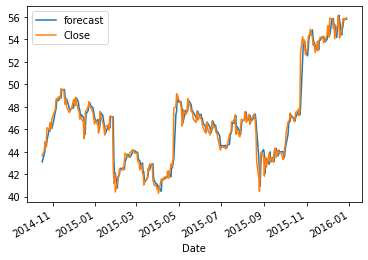

In [153]:

mic_result.plot_predict(start=200, end=500, dynamic=False);

In [154]:
microsoft_train_data, microsoft_test_data = microsoft[0: int(len(microsoft)*0.8)], microsoft[int(len(microsoft)*0.8) :]

<AxesSubplot:xlabel='Date'>

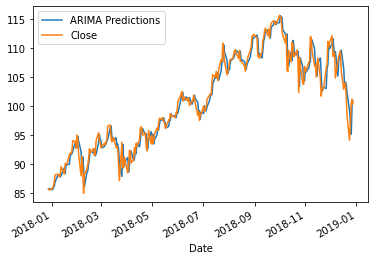

In [155]:
start = len(microsoft_train_data)
end = len(microsoft_train_data) + len(microsoft_test_data)-1
microsoft_pred = mic_result.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')
microsoft_pred.plot(legend=True)
microsoft_test_data['Close'].plot(legend=True)

In [156]:
microsoft_test_data['Close'].mean()

100.90960323999799

In [157]:

microsoft_rmse = sqrt(mean_squared_error(microsoft_pred,microsoft_test_data['Close']))
print(microsoft_rmse)

1.7244157628405137


We can see both from our RMSE score and our plots for all 3 stocks that our model 